In [110]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [111]:
df_surgeries = pd.read_csv("surgeries.csv")
df_spaces = pd.read_csv("ORspaces.csv")

In [112]:
# Model data

# list of surgery IDs
surgeries = df_surgeries["CaseID"].tolist()
# list of OR spaces IDs
spaces = df_spaces["SessionID"].tolist()
# all possible combinations of surgeries and spaces
tasks = gp.tuplelist(list(product(surgeries, spaces)))
# expected duration for each surgery
surgery_duration = pd.Series(df_surgeries["Expected Duration"].values, index=df_surgeries["CaseID"]).to_dict()
# duration of each OR space
space_duration = pd.Series(df_spaces["Duration"].values, index=df_spaces["SessionID"]).to_dict()
# space start times
df_spaces.loc[:, "Start"] = pd.to_timedelta(df_spaces["Start"])
df_spaces.loc[:, "Start"] = df_spaces["Start"].dt.total_seconds() / 60
space_start_time = pd.Series(df_spaces["Start"].values.round(2), index=df_spaces["SessionID"]).to_dict()
# surgery deadlines
df_surgeries.loc[:, "TargetDeadline"] = pd.to_datetime(df_surgeries["TargetDeadline"], format="%d/%m/%Y")
df_surgeries.loc[:, "TargetDeadline"] = df_surgeries["TargetDeadline"].apply(lambda date: date.toordinal()) # Gregorian ordinal for the given DateTime object.
surgery_deadlines = pd.Series(df_surgeries["TargetDeadline"].values, index=df_surgeries["CaseID"]).to_dict()
# Spaces dates
df_spaces.loc[:, "Date"] = pd.to_datetime(df_spaces["Date"], format="%d/%m/%Y")
df_spaces.loc[:, "Date"] = df_spaces["Date"].apply(lambda date: date.toordinal()) # Gregorian ordinal for the given DateTime object.
space_dates = pd.Series(df_spaces["Date"].values, index=df_spaces["SessionID"]).to_dict()

# surgery-surgery-OR space combinations
disjunctions = []
for (surgery1, surgery2, space) in product(surgeries, surgeries, spaces):
    if (surgery1 != surgery2) and (surgery2, surgery1, space) not in disjunctions:
        disjunctions.append((surgery1, surgery2, space))
disjunctions = gp.tuplelist(disjunctions)

In [113]:
#big M
M = 9000

# upper bound (minutes in a day)
upbound = 1440

# upper bound of session utilization set to 90%
max_util = 0.9 # * total OR availability = 1782

# create model
model = gp.Model("OR Utilization")
model.setParam('TimeLimit', 5*60)

# create decision variables
A = model.addVars(tasks, name="session_assigned", vtype=GRB.BINARY)

B = model.addVars(surgeries, name="surgery_start_time", lb=0, ub=upbound)

C = model.addVars(spaces, name="utilization", lb=0, ub=len(surgeries))

D = model.addVars(disjunctions, name="no_overlap", vtype=GRB.BINARY)

# set objective
model.setObjective(C.sum(), GRB.MAXIMIZE)

Set parameter TimeLimit to value 300


In [103]:
# constraint 1: start time of a surgery must be after the start time of the OR space it is assigned to
model.addConstrs((B[c] >= space_start_time[s] - (1 - A[(c,s)])*M for c,s in tasks), name="c1")

# constraint 2: surgery end time must be before end time of OR space
model.addConstrs((B[c] + surgery_duration[c] <= space_start_time[s] + space_duration[s]*max_util + 
                  (1-A[(c,s)])*M for c,s in tasks), name="c2")

# constraint 3: only one OR space per surgery (surgery entries need to be scheduled only once)
for c in surgeries:
    model.addConstr((sum(A[(c,s)] for s in spaces) <= 1), "c3")
    
# constraint 4: surgeries have to be performed before their deadline
model.addConstrs((space_dates[s] <= surgery_deadlines[c] + (1-A[(c,s)])*M for c,s in tasks), name="c4")

#constraint 5: surgeries can't overlap for the same OR space

"""
Ex:

OR availability: {start}||||||||||------surg1------||
                        ||||||||||                 || surg2---||{end}
                        
CanNOT be:
OR availability: {start}||||||||||------surg1------             ||
                        ||||||||||           ----5min + surg2---||{end}

                                        ^OVERLAP ABOVE^
                                        
 x1 = surgery1 start time
 t1 = surgery1 duration
 x2 = surgery2 start time
 t2 = surgery2 duration
 y = {0,1}
 
 Either (x1 + t1 <= x2) or (x2 + t2 <= x1)
 
 If x1 + t1 > x2 then y = 1 and if y = 1 then x2 + t2 <= x1
 If y = 0 then x1 + t1 <= x2
 
                                        
"""
for surg1, surg2, s in disjunctions:
    model.addConstr(B[surg1] + surgery_duration[surg1] <= (B[surg2] + ((2 - A[(surg1,s)] - A[(surg2,s)])*M)) + D[(surg1,surg2,s)]*M, name="c5")
    model.addConstr(B[surg2] + surgery_duration[surg2] <= (B[surg1] + ((2 - A[(surg1,s)] - A[(surg2,s)])*M)) - (1-D[(surg1,surg2,s)])*M, name="c6")
    model.addConstr((D[(surg1,surg2,s)] == 1) >> (B[surg1] + surgery_duration[surg1] >= B[surg2] ), name="c7")
    model.addConstr((D[surg1,surg2,s] == 0) >> (B[surg1] + surgery_duration[surg1] <= B[surg2] ), name="c8")

# constraint 6: linking utilization to # of surgeries assigned
model.addConstrs((C[s] == sum(A[c,s] for c in surgeries) for s in spaces), name="c9")

{1001: <gurobi.Constr *Awaiting Model Update*>,
 1002: <gurobi.Constr *Awaiting Model Update*>,
 1003: <gurobi.Constr *Awaiting Model Update*>,
 1004: <gurobi.Constr *Awaiting Model Update*>}

In [104]:
#model.display()
model.optimize()
#for v in model.getVars():
#    print(v.varName, v.x)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 3874 rows, 1894 columns and 18244 nonzeros
Model fingerprint: 0x71bc428d
Model has 3480 general constraints
Variable types: 34 continuous, 1860 integer (1860 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 2e+04]
  GenCon rhs range [3e+01, 1e+02]
  GenCon coe range [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve added 2768 rows and 0 columns
Presolve removed 0 rows and 18 columns
Presolve time: 0.07s
Presolved: 6642 rows, 1876 columns, 25844 nonzeros
Variable types: 30 continuous, 1846 integer (1846 binary)
Found heuristic solution: objective 2.0000000

Root relaxation: objective 3.000000e+01, 488 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective

In [105]:
model.objVal

30.0

/Users/emanuelhernandez/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/emanuelhernandez/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/emanuelhernandez/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences 

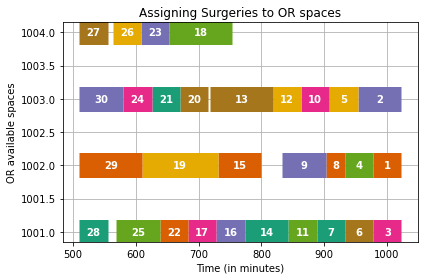

In [108]:
results = [{"Surgery": c,
            "Space": s,
            "Space Date": space_dates[s],
            "Case Deadline": surgery_deadlines[c],
            "Days before deadline": surgery_deadlines[c] - space_dates[s],
            "Start": B[c].x,
            "Assignment": A[c, s].x}
           for (c, s) in tasks]

df_times = pd.DataFrame(results)

df = df_times[df_times["Assignment"] == 1]
surgeries = sorted(list(df['Surgery'].unique()))
spaces = sorted(list(df['Space'].unique()))

bar_style = {'alpha': 1.0, 'lw': 25, 'solid_capstyle': 'butt'}
text_style = {'color': 'white', 'weight': 'bold', 'ha': 'center', 'va': 'center'}
colors = cm.Dark2.colors

df.sort_values(by=['Case', 'Session'])
df.set_index(['Case', 'Session'], inplace=True)

fig, ax = plt.subplots(1, 1)
for c_ix, c in enumerate(surgeries, 1):
    for s_ix, s in enumerate(spaces, 1):
        if (c, s) in df.index:
            xs = df.loc[(c, s), 'Start']
            xf = df.loc[(c, s), 'Start'] + \
                 df_surgeries[df_cases["CaseID"] == c]["Expected Duration"]
            ax.plot([xs, xf], [s] * 2, c=colors[c_ix % 7], **bar_style)
            ax.text((xs + xf) / 2, s, c, **text_style)

ax.set_title('Assigning Surgeries to OR spaces')
ax.set_xlabel('Time (in minutes)')
ax.set_ylabel('OR available spaces')
ax.grid(True)

fig.tight_layout()
plt.show()